# Music Valence Prediction
DAEM dataset | Tensorflow Keras | Convolutional Neural Network

***

## Project Description

### The Objective

The goal of this task is to develop a Python-based module to predict the valence of newly released pop songs.   Two approaches are to use as an input: 
1) the audio data (e.g. `.wav` files) 
2) the songs lyrics

Publicly available datasets can be used for training and testing. 

### Audio Features
<a id="audio-features"></a>

This version of the project implements the approach of the following research paper: [Muic Mood Classification using Convolutional Neural Networks](https://ccrma.stanford.edu/~jansto/documents/EmotionRecognition_Paper.pdf)
The only audio feature that will be used is the Mel-Spectrogram.

### The Dataset

For this task the [DEAM dataset](https://cvml.unige.ch/databases/DEAM/) will be used.

***

## Libraries and settings

In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [17]:
# set up some parameters for plots in this notebook
plt.style.use("seaborn-v0_8-paper")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("cubehelix")
sns.set_context("notebook")

plt.rcParams["figure.figsize"] = (10, 4)
%config InlineBackend.figure_format = "retina"

In [3]:
# save the random state number in advance
seed = 12345

***

## Data Preprocessing

### Annotations data

In [4]:
# read the annotations file
annot = pd.read_csv("datasets/static_annotations_averaged_songs_1_2000.csv")

In [5]:
# show general info
annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB


In [6]:
# print several random rows
annot.sample(3)

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
1403,1660,5.2,1.47,5.5,1.43
1692,1949,2.2,1.54,5.1,2.59
517,668,5.0,1.55,5.3,1.62


The column names contain "mean" and "std" due to the labeling procedure: each song has been labeled by 10 people. The average value of all rates was then taken and the standard deviation was calculated. For this project, this information is not needed.

In [7]:
# the column names contain empty spaces, fix that
annot.columns = [col.replace(" ","") for col in annot.columns]

In [8]:
# drop extra columns
annot.drop(columns=["valence_std","arousal_std"], inplace=True)
# shortent the column names
annot.rename(columns={"valence_mean":"valence", "arousal_mean":"arousal"}, inplace=True)
annot.sample(3)

,song_id,valence,arousal
1106,1363,5.1,3.6
596,769,6.2,5.0
1172,1429,3.0,2.3


### Metadata

In [9]:
# read the meatdata file
meta = pd.read_csv("datasets/metadata_1_2000.csv")

In [10]:
# show general info
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   song_id                         1744 non-null   int64  
 1   file_name                       744 non-null    object 
 2   Artist                          1744 non-null   object 
 3   Song title                      1744 non-null   object 
 4   start of the segment (min.sec)  1744 non-null   float64
 5   end of the segment (min.sec)    1744 non-null   float64
 6   Genre                           1744 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 95.5+ KB


The reason the `file_name` column contains missing values is that this file was compiled from two (with the use of MS Excel) and the second of these files didn't have this information. However, the file names can be derived from the `song_id` column.

In [11]:
# print a sample of the meta set
meta.sample(3)

,song_id,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre
177,210,\t210.mp3,Advent Chamber Orchestra-Bughici \t,\t Suite for Violin 8 Ardeleneascamoderato,0.290000,1.14000,\tClassical\t
560,722,\t722.mp3,Quantum Jazz\t,\tOrbiting A Distant Planet\t,2.320000,3.17000,\tJazz\t
958,1215,NaN,The Cracker Cats,We Plant Trees,52.553764,140.81254,Country-Folk-Pop


The segment points are noted differently for the first 744 song, than it is for the second 100. However, it is known that each audio file in this dataset is 45 seconds length.

In [12]:
# tidy up the column names
meta.columns = ["song_id","file_name","artist","song_title","segment_start","segment_end", "genre"]
# fill in missing song titles
meta["song_title"].fillna("unknown", inplace=True)

In [13]:
# remove artifacts
for col in ["artist","song_title","genre"]:
    meta[col] = [re.sub(r"\t", "", string) for string in meta[col]]

# constract new file_name column
meta["file_name"] = meta["song_id"].astype(str) + ".mp3"

# print sample to check
meta.sample(3)

,song_id,file_name,artist,song_title,segment_start,segment_end,genre
753,1010,1010.mp3,The Relatives,Bad Trip,172.742789,268.400000,Blues-SoulRB-Rock
176,209,209.mp3,Kevin MacLeod,Amazing Grace 2011,0.210000,1.060000,Classical
895,1152,1152.mp3,Lee Maddeford,Finale,226.922789,308.050045,Classical-International-Spoken


### Merge datasets

In [14]:
data = annot.merge(meta, on="song_id",how="outer")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1743
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1   valence        1744 non-null   float64
 2   arousal        1744 non-null   float64
 3   file_name      1744 non-null   object 
 4   artist         1744 non-null   object 
 5   song_title     1744 non-null   object 
 6   segment_start  1744 non-null   float64
 7   segment_end    1744 non-null   float64
 8   genre          1744 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 136.2+ KB


***

## EDA

### Valence vs arousal

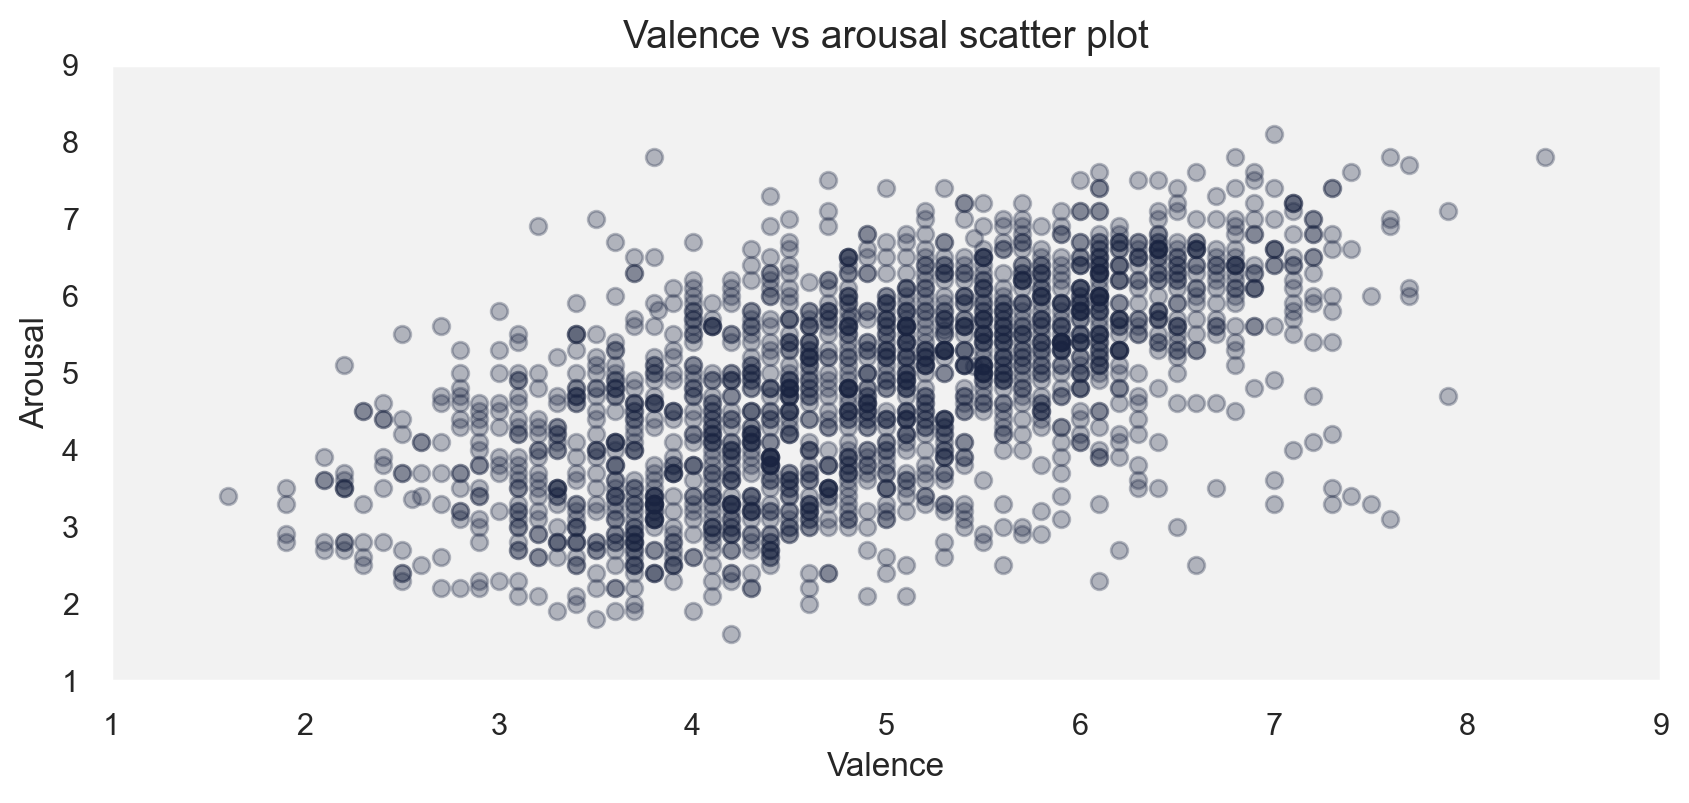

In [18]:
# plot the valence and arousal values distribution
plt.scatter(data["valence"], data["arousal"], alpha=.3)
plt.title("Valence vs arousal scatter plot", fontsize=14)
plt.xlim([1,9])
plt.ylim([1,9])
plt.xlabel("Valence")
plt.ylabel("Arousal");

There is a noticeable general correlation between these values, which is expected.

### Genre classes balance

Unique genres in the dataset:  126



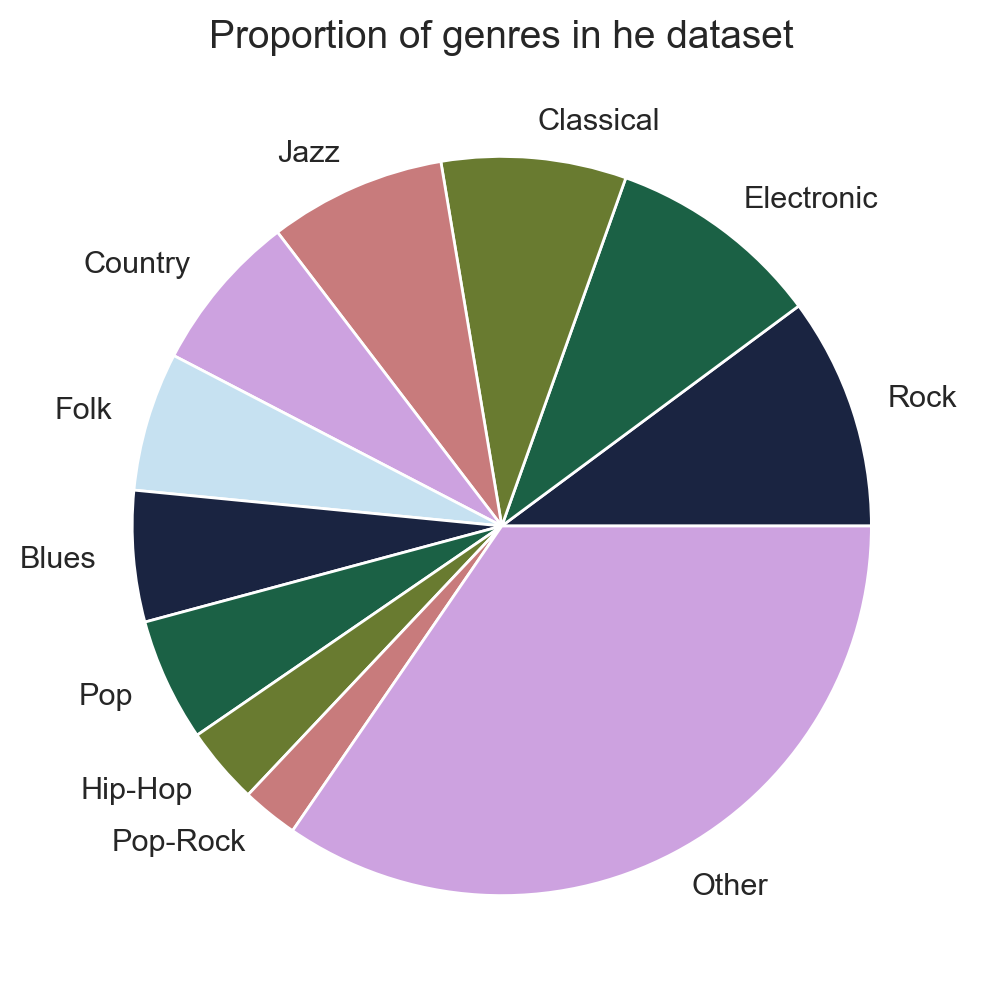

In [19]:
# count the number of genres present in the dataset
nunique_genres = data["genre"].nunique()
print("Unique genres in the dataset:  {}\n".format(nunique_genres))

# select the top 10
top10_genres = data["genre"].value_counts()[:10]
top10_genres.loc["Other"] = data["genre"].value_counts()[10:].sum()

# plot a pie chart with genres ratio
plt.figure(figsize=(6,6))
labels = top10_genres.index
plt.pie(top10_genres, labels=labels)
plt.title("Proportion of genres in he dataset", fontsize=14);

The data contains a variety of music genres. Among the top-10 are present some genres related to this task: Pop, Hip-Hop, Rock, Pop-Rock, and Electronic.

### Audio and waveform

Sampling rate: 22050
song_id                                    1017
valence                                     4.1
arousal                                     3.8
file_name                              1017.mp3
artist                          James Beaudreau
song_title                                 Hare
segment_start                         36.395873
segment_end                          122.162698
genre            SoulRB-Blues-Experimental-Rock
Name: 760, dtype: object


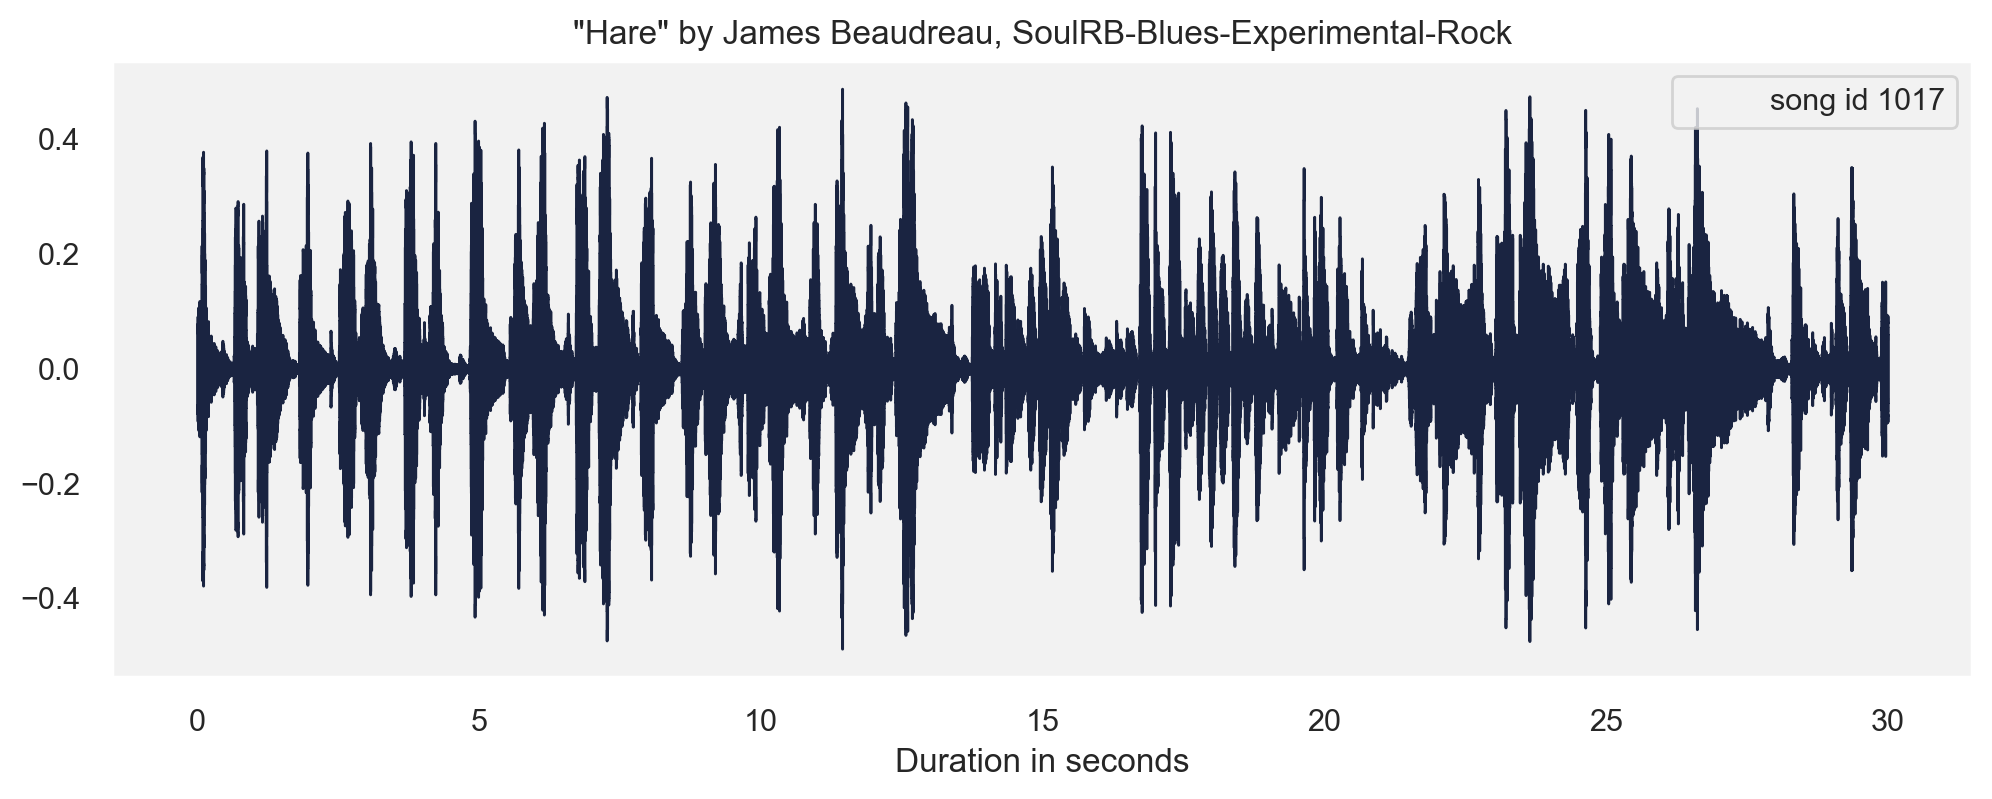

In [49]:
random_idx = np.random.randint(0, 1744)

# select a reference song from the dataset
song = data.loc[random_idx, :]

# load the file and print its sampling rate 
file_path = "datasets/audio_files/" + song["file_name"]
y, sr = librosa.load(file_path, duration=30) # select only 30 seconds
# print info about this song
print(f"Sampling rate: {sr}")
print(song)

# plot the wavefrom
plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr) # plot a waveform and play the file
plt.title(f'"{song.song_title[:15]}" by {song.artist}, {song.genre}')
plt.legend([f"song id {song.song_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

Some songs don't sound like they belong to the genre with which they were associated. For example, [song 402](https://freemusicarchive.org/music/Patrick_Lee/Bad_Panda_42/Quittin_Time/) is way more funk than electronic, but it was marked as Electronic in the dataset, and [song 43](https://freemusicarchive.org/music/The_Agrarians/Uncomfortably_Songwriter_Vol_VI/Puritans_Too_1938/) can barely be described as Blues.

***

## Feature Preprocessing

The audio files need to be converted to mono and then resampled with a Sampling Frequency fs = 16000 Hz to save computing time. To avoid the association of loudness with emotion, all songs need to be normalized to a range from -1.0 to + 1.0. The songs are then converted to Mel-spectograms with the sample rate fs = 16000 Hz and a number of
80 bins. The Power is converted to db.

### Procedure

In [65]:
# load the audio file and resample
y, sr = librosa.load(file_path, duration=30, mono=True)
y = librosa.resample(y, orig_sr=sr, target_sr=16000)

# normalize from -1 to 1
y = librosa.util.normalize(y)

# obtain melspectogram with 80 freq. bins
mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=80)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

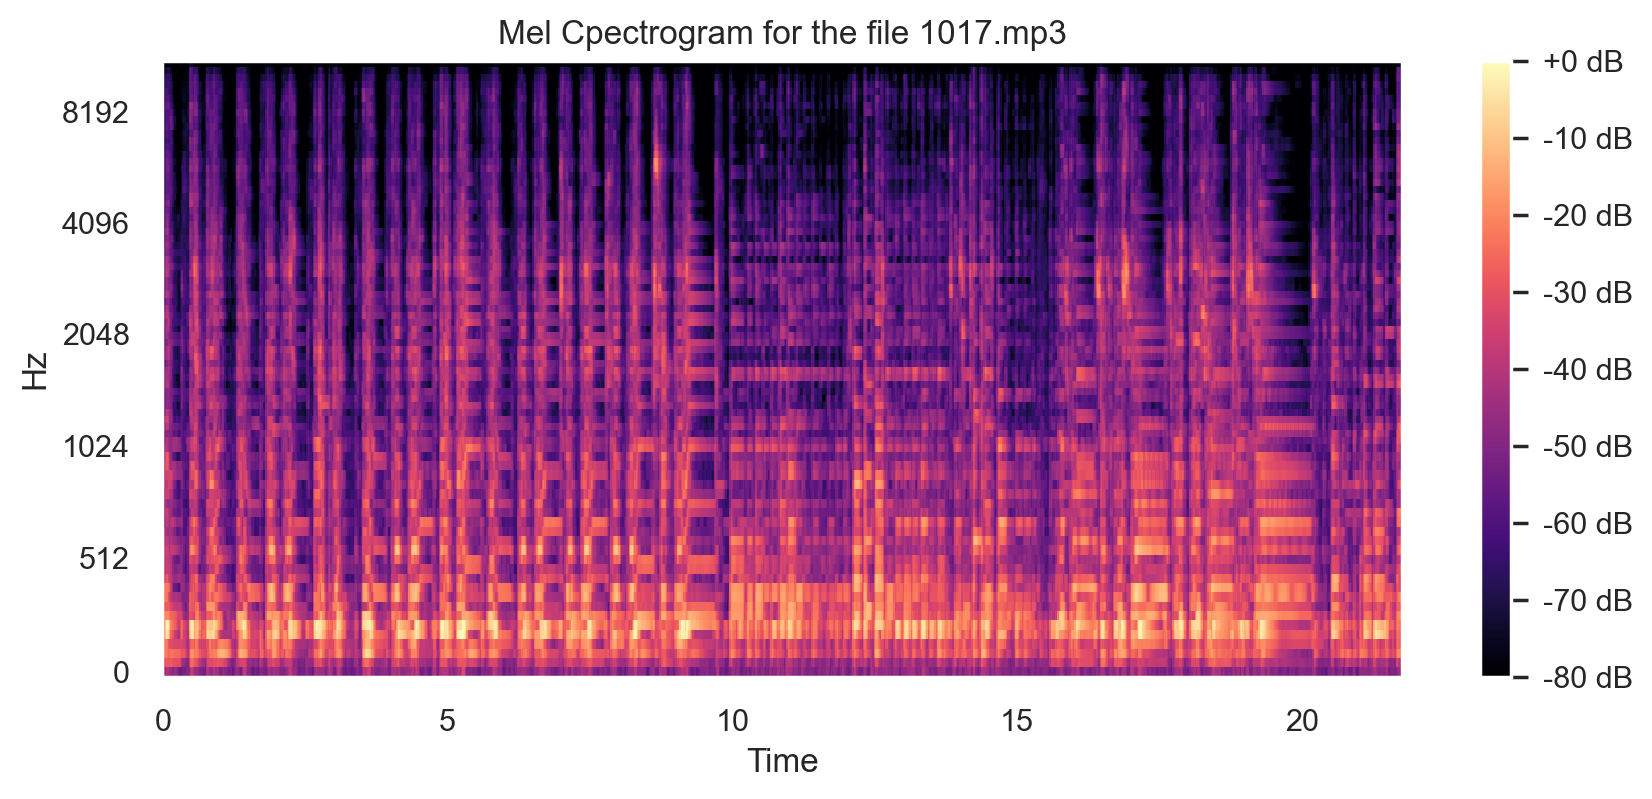

In [66]:
# show the resulting spectogram
librosa.display.specshow(mel_spec, y_axis='mel', x_axis='time')
plt.title("Mel Cpectrogram for the file {}".format(song.file_name));
plt.colorbar(format='%+2.0f dB');

### Extract Features

In [70]:
# features = []

# for i in tqdm(range(len(data))):
    
#     file_name = data.loc[i, "file_name"]
#     file_path = "datasets/audio_files/" + file_name
    
#     y, sr = librosa.load(file_path, duration=30, mono=True)
#     y = librosa.resample(y, orig_sr=sr, target_sr=16000)

#     y = librosa.util.normalize(y)

#     mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=80)
#     mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
#     features.append(mel_spec)
    
# features = np.array(features)

  0%|                                                  | 0/1744 [00:00<?, ?it/s]/Users/ioann/miniconda3/envs/tensorflow/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
100%|███████████████████████████████████████| 1744/1744 [20:40<00:00,  1.41it/s]


In [81]:
# # save extracted feaures
# for i in tqdm(range(len(data))):
#     song_id = data.loc[i, "song_id"]
#     np.savetxt("datasets/mel_spec_features_2022-12-28/" + str(song_id) + ".csv", 
#                features[i], delimiter=",")

100%|███████████████████████████████████████| 1744/1744 [00:48<00:00, 35.70it/s]


In [104]:
# load fetures
features = []

for i in tqdm(range(len(data))):
    song_id = data.loc[i, "song_id"]
    feature = pd.read_csv(
        "datasets/mel_spec_features_2022-12-28/" + str(song_id) + ".csv", 
        index_col=0).values
    
    features.append(feature)
    
features = np.array(features)

100%|███████████████████████████████████████| 1744/1744 [00:31<00:00, 54.87it/s]


### Split the data

In [84]:
X = features
y = data.valence.values

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=seed)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1046, 80, 938)
(349, 80, 938)
(349, 80, 938)


***

## Model training

In [94]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [111]:
# build the model
model = Sequential()
optimizer = Adam(learning_rate=0.01)

model.add(
    Conv2D(filters=16, kernel_size=(3, 3), 
           activation="relu", input_shape=(80, 938, 1))
)
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(1))

model.compile(
    loss="mean_squared_error", 
    metrics=["mean_absolute_error"], 
    optimizer=optimizer
)

In [112]:
# train the model
num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath="saved_models/valence_predicition.hdf5",
                              verbose=1, save_best_only=True)

# initialize callbacks
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_mean_absolute_error", 
                                                patience=5, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

In [113]:
# fit the model
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    # batch_size=num_batch_size,
    epochs=num_epochs,
    callbacks=[checkpointer, earlystop, learning_rate_reduction],
    verbose=1
)

Epoch 1/200


2022-12-28 15:27:50.024936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 18.2807 - mean_absolute_error: 4.0590

2022-12-28 15:27:51.591411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3.28920, saving model to saved_models/valence_predicition.hdf5
33/33 [==============================] - 2s 50ms/step - loss: 18.2807 - mean_absolute_error: 4.0590 - val_loss: 3.2892 - val_mean_absolute_error: 1.4815 - lr: 0.0100
Epoch 2/200
33/33 [==============================] - ETA: 0s - loss: 4.5065 - mean_absolute_error: 1.7426
Epoch 2: val_loss did not improve from 3.28920
33/33 [==============================] - 1s 40ms/step - loss: 4.5065 - mean_absolute_error: 1.7426 - val_loss: 29.9391 - val_mean_absolute_error: 5.3134 - lr: 0.0100
Epoch 3/200
33/33 [==============================] - ETA: 0s - loss: 1.7069 - mean_absolute_error: 1.0424
Epoch 3: val_loss did not improve from 3.28920
33/33 [==============================] - 1s 39ms/step - loss: 1.7069 - mean_absolute_error: 1.0424 - val_loss: 15.2446 - val_mean_absolute_error: 3.7717 - lr: 0.0100
Epoch 4/200
33/33 [==============================] - ETA: 0s - loss: 1.5327 - mean_absolute_e